In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import scipy.stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split

In [8]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")

# Clean n Prep for Train dataset

In [11]:
df_train.shape

(165034, 14)

In [740]:
#Drop unuseful columns
df_train=df_train.drop(columns=['id','CustomerId'])

In [741]:
#Examine duplicates
df_train.duplicated().sum()

54

In [742]:
#Visualize the duplicates
df_train1=df_train[df_train.duplicated(keep=False)]
display(df_train1.sort_values(by=df_train1.columns.tolist()))

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
60181,Barclay-Harvey,513,France,Male,44.0,1,63562.02,2,1.0,1.0,52629.73,0
115924,Barclay-Harvey,513,France,Male,44.0,1,63562.02,2,1.0,1.0,52629.73,0
48622,Black,641,France,Male,33.0,2,0.00,2,1.0,1.0,55796.83,0
119071,Black,641,France,Male,33.0,2,0.00,2,1.0,1.0,55796.83,0
137330,Brennan,765,France,Female,50.0,9,126547.80,1,1.0,1.0,79579.94,0
...,...,...,...,...,...,...,...,...,...,...,...,...
144132,Wright,632,France,Male,50.0,2,0.00,2,1.0,0.0,57942.88,0
20378,Yobachi,449,Spain,Female,33.0,8,0.00,2,1.0,0.0,156792.89,0
21512,Yobachi,449,Spain,Female,33.0,8,0.00,2,1.0,0.0,156792.89,0
30063,Young,606,Germany,Male,27.0,2,130274.26,2,1.0,1.0,147533.09,0


In [743]:
#Drop duplicates, keep the og data
df_train=df_train.drop_duplicates(keep='first')
print("Duplicates after drop:", df_train.duplicated().sum())

Duplicates after drop: 0


In [744]:
#Drop Surname because it doesn't add much value now
df_train=df_train.drop(columns=['Surname'])

In [745]:
df_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [746]:
#Encode Categorical data

encoder=OneHotEncoder(sparse_output=False)

en = encoder.fit_transform(df_train[['Geography','Gender']]) # = Categorical variables to be encoded

encoded_df = pd.DataFrame(en, columns=encoder.get_feature_names_out(['Geography', 'Gender']))#give name after encoding for easy identification

train_encoded = pd.concat([df_train.drop(['Geography', 'Gender'], axis=1), encoded_df], axis=1) #drop old and combine new columns into 1 df


In [747]:
#Check encoded performance 
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165033 entries, 0 to 164350
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        164980 non-null  float64
 1   Age                164980 non-null  float64
 2   Tenure             164980 non-null  float64
 3   Balance            164980 non-null  float64
 4   NumOfProducts      164980 non-null  float64
 5   HasCrCard          164980 non-null  float64
 6   IsActiveMember     164980 non-null  float64
 7   EstimatedSalary    164980 non-null  float64
 8   Exited             164980 non-null  float64
 9   Geography_France   164980 non-null  float64
 10  Geography_Germany  164980 non-null  float64
 11  Geography_Spain    164980 non-null  float64
 12  Gender_Female      164980 non-null  float64
 13  Gender_Male        164980 non-null  float64
dtypes: float64(14)
memory usage: 18.9 MB


In [748]:
#Feature scaling 
scale_standard= StandardScaler()

cols_to_scale=['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']

standard_data = scale_standard.fit_transform(df_train[cols_to_scale])
scaled_standard_df = pd.DataFrame(standard_data, columns=cols_to_scale)

In [749]:
#make new df combine encode + standardized 

train_processed=pd.concat([scaled_standard_df, encoded_df, df_train[['HasCrCard','IsActiveMember','Exited']].reset_index(drop=True)], axis=1)
train_processed.head(5)

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember,Exited
0,0.144025,-0.578123,-0.720006,0.814363,-0.883233,1.369474,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
1,-0.367858,-0.578123,-1.432713,0.814363,-0.883233,-1.254161,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0
2,0.268874,0.211406,1.774469,0.814363,-0.883233,1.437412,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,-0.942166,-0.465333,-1.076359,-1.013254,1.486778,-0.557077,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0
4,0.743302,-0.578123,-0.007299,0.814363,-0.883233,-1.938863,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0


In [750]:
train_processed.shape

(164980, 14)

In [751]:
df_train.shape

(164980, 11)

# Clean N Prep for Test Dataset

In [13]:
df_test.shape

(110023, 13)

In [753]:
#Make a copy to use later for id column in submission file 
df_test1=df_test.copy()

In [754]:
df_test.head(7)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
5,165039,15672704,Pearson,593,France,Female,22.0,9,0.00,2,0.0,0.0,51907.72
6,165040,15647838,Onyemere,682,Spain,Male,45.0,4,0.00,2,1.0,1.0,157878.67


In [755]:
#Dropping unnecessary columns
df_test=df_test.drop(columns=['id','CustomerId'])

In [756]:
#Test for duplicates
df_test.duplicated().sum()

36

In [757]:
#Visualize the duplicates
df_testt=df_test[df_test.duplicated(keep=False)]
display(df_testt.sort_values(by=df_testt.columns.tolist()))

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7206,Belisario,630,France,Male,50.0,8,0.00,2,0.0,0.0,79377.45
98244,Belisario,630,France,Male,50.0,8,0.00,2,0.0,0.0,79377.45
1556,Bess,648,France,Female,41.0,2,0.00,2,1.0,1.0,58652.23
8850,Bess,648,France,Female,41.0,2,0.00,2,1.0,1.0,58652.23
59104,Black,769,France,Male,27.0,2,0.00,1,1.0,1.0,57876.05
...,...,...,...,...,...,...,...,...,...,...,...
73667,Wilson,728,Spain,Female,37.0,6,0.00,2,0.0,0.0,4539.38
62095,Y?an,713,France,Male,46.0,5,0.00,1,1.0,1.0,55701.62
85399,Y?an,713,France,Male,46.0,5,0.00,1,1.0,1.0,55701.62
82476,Yobachukwu,850,Spain,Male,41.0,8,132838.07,1,1.0,0.0,175347.28


In [758]:
#Drop duplicates, keep the 1st appearance of og data
duplicates = df_test[df_test.duplicated()].index #keep indices to update copied df
df_test=df_test.drop(duplicates)
print("Duplicates after drop:", df_test.duplicated().sum())

Duplicates after drop: 0


In [759]:
#drop rows in copied df too

df_test1=df_test1.drop(duplicates)

In [760]:
#reinstate id column into df
df_test['id']=df_test1['id'].values

In [761]:
df_test.head(7)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,id
0,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,165034
1,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,165035
2,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,165036
3,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,165037
4,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,165038
5,Pearson,593,France,Female,22.0,9,0.00,2,0.0,0.0,51907.72,165039
6,Onyemere,682,Spain,Male,45.0,4,0.00,2,1.0,1.0,157878.67,165040


In [762]:
#Drop Surname because not suitable for ML
df_test=df_test.drop(columns=['Surname'])

In [763]:
df_test.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'id'],
      dtype='object')

In [764]:
#Encode Categorical data

encoder=OneHotEncoder(sparse_output=False)

enn = encoder.fit_transform(df_test[['Geography','Gender']]) # = Categorical variables to be encoded

encoded = pd.DataFrame(enn, columns=encoder.get_feature_names_out(['Geography', 'Gender']))#give name after encoding for easy identification
encoded= encoded.reset_index(drop=True)

test_encoded = pd.concat([df_test.drop(['Geography', 'Gender'], axis=1), encoded], axis=1) #drop old and combine new columns into 1 df


In [765]:
#Check encoded performance 
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110023 entries, 0 to 109841
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        109987 non-null  float64
 1   Age                109987 non-null  float64
 2   Tenure             109987 non-null  float64
 3   Balance            109987 non-null  float64
 4   NumOfProducts      109987 non-null  float64
 5   HasCrCard          109987 non-null  float64
 6   IsActiveMember     109987 non-null  float64
 7   EstimatedSalary    109987 non-null  float64
 8   id                 109987 non-null  float64
 9   Geography_France   109987 non-null  float64
 10  Geography_Germany  109987 non-null  float64
 11  Geography_Spain    109987 non-null  float64
 12  Gender_Female      109987 non-null  float64
 13  Gender_Male        109987 non-null  float64
dtypes: float64(14)
memory usage: 12.6 MB


In [766]:
#keep copy of id column to use for submission 
id_column=df_test['id'].copy() 
id_column= id_column.reset_index(drop=True)

In [767]:
#Drop id because not suitable for ML
df_test=df_test.drop(columns=['id'])

In [768]:
#Feature scaling 
scale_standard= StandardScaler()

cols_to_scale=['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']

standard_df = scale_standard.fit_transform(df_test[cols_to_scale])
scaled_df = pd.DataFrame(standard_df, columns=cols_to_scale)
scaled_df= scaled_df.reset_index(drop=True)


In [769]:
#make new df combine encode + standardized 

test_processed=pd.concat([scaled_df, encoded, df_test[['HasCrCard','IsActiveMember']].reset_index(drop=True)], axis=1)
test_processed.head(5)

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember
0,-0.878349,-1.706535,-1.067925,0.819972,-0.881281,0.967765,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.329503,0.888901,-1.067925,-1.015881,-0.881281,-0.791103,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.006703,-0.465240,0.713899,0.819972,-0.881281,0.528291,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.304599,-0.239549,1.070264,-1.015881,-0.881281,0.032012,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.188697,-0.013859,1.782993,-1.015881,1.050085,0.539209,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [770]:
#Check that id and df are same length to reinstate later
assert len(id_column) == len(test_processed)

# Train

In [772]:
#Split train data set: x - 80% train | 20% test   y - Target
X= train.drop('Exited', axis=1)
y= train['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Score results
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     25132
           1       0.52      0.79      0.63      6452

    accuracy                           0.81     31584
   macro avg       0.73      0.80      0.75     31584
weighted avg       0.85      0.81      0.82     31584



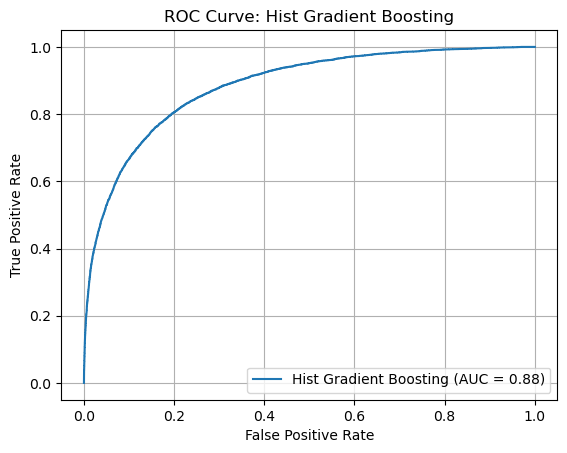

In [773]:
#Fitting classifier with best parameters

X= train.drop('Exited', axis=1)
y= train['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf= HistGradientBoostingClassifier(class_weight='balanced', max_iter=610, max_depth=3, learning_rate=0.076, l2_regularization=6.5, 
                                    max_leaf_nodes=19, min_samples_leaf=29, early_stopping=False, random_state=42)
clf.fit(X_train, y_train)

#getting performance
y_score= clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc= auc(fpr, tpr)


print("Score results")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

#Graph ROC Curve
plt.plot(fpr, tpr, label='Hist Gradient Boosting (AUC = %.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Hist Gradient Boosting')
plt.legend()
plt.grid()

In [774]:
#Run several more rounds to reduce evaluation bias
score = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

print(" HGB Cross-validation scores:", score)
print("Average score:", score.mean())

 HGB Cross-validation scores: [0.89106328 0.88504525 0.88790427 0.88654311 0.88707219]
Average score: 0.887525619162221


# Test

In [819]:
#Evaluating performance using chalenge's test dataset

x=test_processed 
test_pred= clf.predict_proba(x)[:,1]
test_pred_rounded = test_pred.round(1)

#make submission file
submission=pd.DataFrame({ 'id': id_column, 
                         'Exited': test_pred_rounded })

submission.to_csv('submission.csv', index=False, header=True)

In [821]:
len(submission)

109987